# Medical Image Classification with PyHealth

Welcome to the PyHealth tutorial on image classification. In this notebook, we will explore how to use PyHealth to analyze chest X-ray images and classify them into various chest diseases.

## Environment Setup

To begin, we need to install PyHealth and a few additional packages to support our analysis.

In [1]:
!pip install mne pandarallel rdkit transformers

In [2]:
!rm -rf PyHealth
!git clone -b zhenbang/f-image_text_support https://github.com/sunlabuiuc/PyHealth.git

Cloning into 'PyHealth'...
remote: Enumerating objects: 8280, done.
remote: Counting objects: 100% (8280/8280), done.
remote: Compressing objects: 100% (2849/2849), done.
remote: Total 8280 (delta 5454), reused 7866 (delta 5278), pack-reused 0
Receiving objects: 100% (8280/8280), 120.91 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (5454/5454), done.


In [3]:
import sys


sys.path.append("./PyHealth")

## Download Data

Next, we will download the dataset containing COVID-19 data. This dataset includes chest X-ray images of normal cases, lung opacity, viral pneumonia, and COVID-19 patients. You can find more information about the dataset [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

This dataset is hosted on Google Cloud, so the download speed should be relatively fast, taking approximately 10 seconds to complete.

In [4]:
!wget -N https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip

--2024-02-05 01:13:08--  https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘archive.zip’ not modified on server. Omitting download.



In [5]:
!unzip -q -o archive.zip

In [6]:
!ls -1 COVID-19_Radiography_Dataset

COVID
COVID.metadata.xlsx
Lung_Opacity
Lung_Opacity.metadata.xlsx
Normal
Normal.metadata.xlsx
README.md.txt
'Viral Pneumonia'
'Viral Pneumonia.metadata.xlsx'


Next, we will proceed with the chest X-ray classification task using PyHealth, following a five-stage pipeline.

## Step 1. Load Data in PyHealth

The initial step involves loading the data into PyHealth's internal structure. This process is straightforward: import the appropriate dataset class from PyHealth and specify the root directory where the raw dataset is stored. PyHealth will handle the dataset processing automatically.

In [7]:
from pyhealth.datasets import COVID19CXRDataset


root = "/content/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

Once the data is loaded, we can perform simple queries on the dataset.

In [8]:
base_dataset.stat()

Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


In [9]:
base_dataset.patients[0]

{'path': '/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png',
 'url': 'https://sirm.org/category/senza-categoria/covid-19/',
 'label': 'COVID'}

## Step 2. Define the Task

The next step is to define the machine learning task. This step instructs the package to generate a list of samples with the desired features and labels based on the data for each individual patient. Please note that in this dataset, patient identification information is not available. Therefore, we will assume that each chest X-ray belongs to a unique patient.

For this dataset, PyHealth offers a default task specifically for chest X-ray classification. This task takes the image as input and aims to predict the chest diseases associated with it.

In [10]:
base_dataset.default_task

COVID19CXRClassification(task_name='COVID19CXRClassification', input_schema={'path': 'image'}, output_schema={'label': 'label'})

In [11]:
sample_dataset = base_dataset.set_task()

Generating samples for COVID19CXRClassification: 100%|██████████| 21165/21165 [00:00<00:00, 1187924.96it/s]


Additionally, let's define a transformation function for the X-ray image. This function will resize the image to 224x224 pixels, convert it to grayscale, and normalize the pixel values.

In [12]:
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.Normalize(mean=[0.5862785803043838], std=[0.27950088968644304])
])


def encode(sample):
    sample["path"] = transform(sample["path"])
    return sample


sample_dataset.set_transform(encode)

Here is an example of a single sample, represented as a dictionary. The dictionary contains keys for feature names, label names, and other metadata associated with the sample.

In [13]:
sample_dataset[0]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'path': tensor([[[-0.0679, -1.8486, -2.0976,  ..., -2.0858, -1.9487, -0.6912],
          [-1.5782, -2.0419, -2.0976,  ..., -2.0847, -2.0557, -1.7701],
          [-2.0739, -2.0895, -2.0976,  ..., -2.0816, -2.0286, -1.8701],
          ...,
          [-1.1680, -1.2323, -1.0222,  ..., -2.0809, -2.0149, -1.9473],
          [-0.8756, -1.1191, -0.9243,  ..., -2.0930, -1.9579, -1.4143],
          [-0.1718, -0.9416, -0.8654,  ..., -2.0953, -1.8020, -0.2139]]]),
 'url': 'https://sirm.org/category/senza-categoria/covid-19/',
 'label': 'COVID'}

We can also check the input and output schemas, which specify the data types of the features and labels.

In [14]:
sample_dataset.input_schema

{'path': <pyhealth.datasets.featurizers.image.ImageFeaturizer at 0x7f6876f6de70>}

In [15]:
sample_dataset.output_schema

{'label': ValueFeaturizer()}

Below, we plot the number of samples per classes, and visualize some samples.

defaultdict(<class 'int'>, {'COVID': 3616, 'Lung Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 1345})


<BarContainer object of 4 artists>

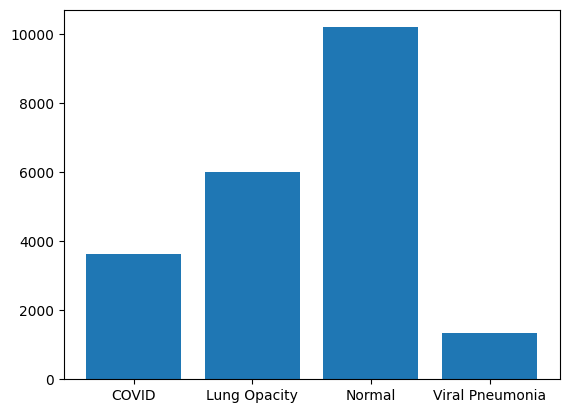

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt


label_counts = defaultdict(int)
for sample in sample_dataset.samples:
    label_counts[sample ["label"]] += 1
print(label_counts)
plt.bar(label_counts.keys(), label_counts.values())

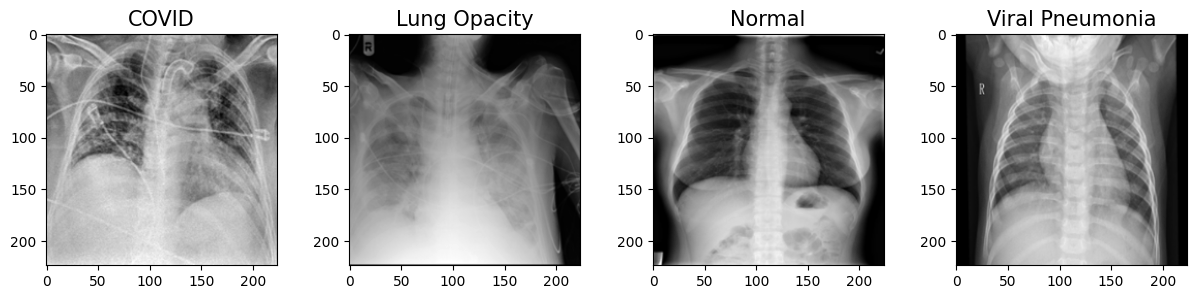

In [17]:
import random


label_to_idxs = defaultdict(list)
for idx, sample in enumerate(sample_dataset.samples):
    label_to_idxs[sample["label"]].append(idx)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for ax, label in zip(axs, label_to_idxs.keys()):
    ax.set_title(label, fontsize=15)
    idx = random.choice(label_to_idxs[label])
    sample = sample_dataset[idx]
    image = sample["path"][0]
    ax.imshow(image, cmap="gray")

Finally, we will split the entire dataset into training, validation, and test sets using the ratios of 70%, 10%, and 20%, respectively. We will then obtain the corresponding data loaders for each set.

In [18]:
from pyhealth.datasets import split_by_sample


train_dataset, val_dataset, test_dataset = split_by_sample(
    dataset=sample_dataset,
    ratios=[0.8, 0.1, 0.1]
)

In [19]:
from pyhealth.datasets import get_dataloader


train_dataloader = get_dataloader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

## Step 3. Define the Model

Next, we will define the deep learning model we want to use for our task. PyHealth supports all major vision models available in the Torchvision package. You can load any of these models using the model_name argument.

In [20]:
from pyhealth.models import TorchvisionModel


resnet = TorchvisionModel(
    dataset=sample_dataset,
    feature_keys=["path"],
    label_key="label",
    mode="multiclass",
    model_name="resnet34",
    model_config={"weights": "DEFAULT"}
)

resnet

TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr


## Step 4. Training


In this step, we will train the model using PyHealth's Trainer class, which simplifies the training process and provides standard functionalities.

Let us first train the ResNet model.

In [21]:
from pyhealth.trainer import Trainer


resnet_trainer = Trainer(model=resnet)

TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

INFO:pyhealth.trainer:TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

Metrics: None


INFO:pyhealth.trainer:Metrics: None


Device: cuda


INFO:pyhealth.trainer:Device: cuda


INFO:pyhealth.trainer:


Before we begin training, let's first evaluate the initial performance of the model.

In [22]:
print(resnet_trainer.evaluate(test_dataloader))

Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 67/67 [00:13<00:00,  4.97it/s]

{'accuracy': 0.28719886632026453, 'f1_macro': 0.11415282548901558, 'f1_micro': 0.28719886632026453, 'loss': 1.6126743750785715}


Now, let's start the training process. Due to computational constraints, we will train the model for only a few epochs.

In [23]:
resnet_trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=3,
    monitor="f1_macro"
)

Training:


INFO:pyhealth.trainer:Training:


Batch size: 32


INFO:pyhealth.trainer:Batch size: 32


Optimizer: <class 'torch.optim.adam.Adam'>


INFO:pyhealth.trainer:Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}


INFO:pyhealth.trainer:Optimizer params: {'lr': 0.001}


Weight decay: 0.0


INFO:pyhealth.trainer:Weight decay: 0.0


Max grad norm: None


INFO:pyhealth.trainer:Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f6792c56b60>


INFO:pyhealth.trainer:Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f6792c56b60>


Monitor: f1_macro


INFO:pyhealth.trainer:Monitor: f1_macro


Monitor criterion: max


INFO:pyhealth.trainer:Monitor criterion: max


Epochs: 3


INFO:pyhealth.trainer:Epochs: 3


INFO:pyhealth.trainer:


Epoch 0 / 3:   0%|          | 0/530 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


--- Train epoch-0, step-530 ---


INFO:pyhealth.trainer:--- Train epoch-0, step-530 ---


loss: 0.3585


INFO:pyhealth.trainer:loss: 0.3585
Evaluation: 100%|██████████| 67/67 [00:08<00:00,  7.67it/s]

--- Eval epoch-0, step-530 ---



INFO:pyhealth.trainer:--- Eval epoch-0, step-530 ---


accuracy: 0.9211


INFO:pyhealth.trainer:accuracy: 0.9211


f1_macro: 0.9205


INFO:pyhealth.trainer:f1_macro: 0.9205


f1_micro: 0.9211


INFO:pyhealth.trainer:f1_micro: 0.9211


loss: 0.2336


INFO:pyhealth.trainer:loss: 0.2336


New best f1_macro score (0.9205) at epoch-0, step-530


INFO:pyhealth.trainer:New best f1_macro score (0.9205) at epoch-0, step-530


INFO:pyhealth.trainer:


Epoch 1 / 3:   0%|          | 0/530 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


--- Train epoch-1, step-1060 ---


INFO:pyhealth.trainer:--- Train epoch-1, step-1060 ---


loss: 0.2312


INFO:pyhealth.trainer:loss: 0.2312
Evaluation: 100%|██████████| 67/67 [00:08<00:00,  7.66it/s]

--- Eval epoch-1, step-1060 ---



INFO:pyhealth.trainer:--- Eval epoch-1, step-1060 ---


accuracy: 0.9197


INFO:pyhealth.trainer:accuracy: 0.9197


f1_macro: 0.9201


INFO:pyhealth.trainer:f1_macro: 0.9201


f1_micro: 0.9197


INFO:pyhealth.trainer:f1_micro: 0.9197


loss: 0.2174


INFO:pyhealth.trainer:loss: 0.2174


INFO:pyhealth.trainer:


Epoch 2 / 3:   0%|          | 0/530 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


--- Train epoch-2, step-1590 ---


INFO:pyhealth.trainer:--- Train epoch-2, step-1590 ---


loss: 0.1910


INFO:pyhealth.trainer:loss: 0.1910
Evaluation: 100%|██████████| 67/67 [00:08<00:00,  7.58it/s]

--- Eval epoch-2, step-1590 ---



INFO:pyhealth.trainer:--- Eval epoch-2, step-1590 ---


accuracy: 0.8814


INFO:pyhealth.trainer:accuracy: 0.8814


f1_macro: 0.8676


INFO:pyhealth.trainer:f1_macro: 0.8676


f1_micro: 0.8814


INFO:pyhealth.trainer:f1_micro: 0.8814


loss: 0.3578


INFO:pyhealth.trainer:loss: 0.3578


Loaded best model


INFO:pyhealth.trainer:Loaded best model


After training the model, we can compare its performance before and after. We should expect to see an increase in the accuracy score as the model learns from the training data.

## Step 5. Evaluation

Lastly, we can eavluate the ResNet model on the test set. This can be done using PyHealth's `Trainer.evaluate()` function.

In [24]:
print(resnet_trainer.evaluate(test_dataloader))

Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 67/67 [00:08<00:00,  7.60it/s]

{'accuracy': 0.9107227208313652, 'f1_macro': 0.9096203870725038, 'f1_micro': 0.9107227208313652, 'loss': 0.2695156387539942}


Additionally, you can perform inference using the `Trainer.inference()` function.

In [25]:
y_true, y_prob, loss = resnet_trainer.inference(test_dataloader)
y_pred = y_prob.argmax(axis=1)

Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 67/67 [00:08<00:00,  7.66it/s]


Below we show a confusion matrix of the trained ResNet model.

Text(50.722222222222214, 0.5, 'True')

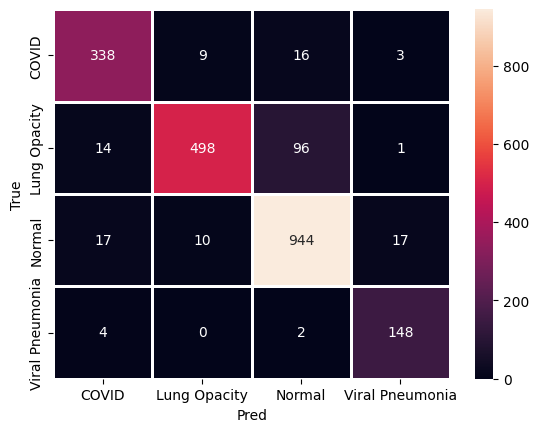

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
ax.set_xticklabels(resnet.label_tokenizer.convert_indices_to_tokens(list(range(4))))
ax.set_yticklabels(resnet.label_tokenizer.convert_indices_to_tokens(list(range(4))))
ax.set_xlabel("Pred")
ax.set_ylabel("True")